## Training MURA from scracth

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from datetime import datetime
import cv2

In [2]:
import os
from tqdm import tqdm_notebook

In [5]:
PATH = Path("/home/datasets/MURA/")
list(PATH.iterdir())

[PosixPath('/home/datasets/MURA/train_350_270'),
 PosixPath('/home/datasets/MURA/MURA-v1.1'),
 PosixPath('/home/datasets/MURA/MURA-v1.1.zip'),
 PosixPath('/home/datasets/MURA/valid_350_270')]

## Preprocessing 

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [7]:
def get_base_path(path):
    return os.path.split(path)[0] + "/"

In [8]:
df = pd.read_csv(PATH/"MURA-v1.1/train_image_paths.csv", header=None, names=["image_name"])
df2 = pd.read_csv(PATH/"MURA-v1.1/train_labeled_studies.csv", header=None, names=["path", "label"])
df["path"] = df["image_name"].apply(get_base_path)
result = pd.merge(df, df2, on='path')
result["image_id"] = result.index
result.to_csv(PATH/"MURA-v1.1/train_path_labels.csv")

In [9]:
df3 = pd.read_csv(PATH/"MURA-v1.1/valid_image_paths.csv", header=None, names=["image_name"])
df4 = pd.read_csv(PATH/"MURA-v1.1/valid_labeled_studies.csv", header=None, names=["path", "label"])
df3["path"] = df3["image_name"].apply(get_base_path)
result2 = pd.merge(df3, df4, on='path')
result2["image_id"] = result2.index
result2.to_csv(PATH/"MURA-v1.1/valid_path_labels.csv")

In [25]:
result.head()

,image_name,path,label,image_id
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,2
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,3
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,4


In [26]:
result.path.values[0].split("/")[3]

'patient00001'

In [27]:
def get_patient_id(path):
    return path.split("/")[3]

In [28]:
result["patient_id"] = result["path"].apply(get_patient_id)

In [29]:
len(result["patient_id"].unique())

11184

In [35]:
sample_example = result["patient_id"].unique()[:3]
sample_example

array(['patient00001', 'patient00002', 'patient00003'], dtype=object)

In [36]:
sample_df = result[result.patient_id.isin(sample_example)]

In [37]:
sample_df

,image_name,path,label,image_id,patient_id
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0,patient00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,1,patient00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,2,patient00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,3,patient00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,4,patient00002
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,5,patient00002
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,6,patient00003
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,7,patient00003
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,8,patient00003


In [25]:
sizes = [read_image(PATH/x).shape for x in df["image_name"].values]

In [49]:
np.quantile([x[0] for x in sizes], 0.001)

177.80700000000002

In [28]:
sz = {}
for x in sizes:
    sz[x] = sz.get(x, 0) + 1

In [32]:
sz2 = {}
for x in sizes:
    ratio = x[0]/x[1]
    key = str(round(ratio,1))
    sz2[key] = sz2.get(key, 0) + 1

In [38]:
x, y = [float(x) for x in sz2.keys()], sz2.values()

<BarContainer object of 50 artists>

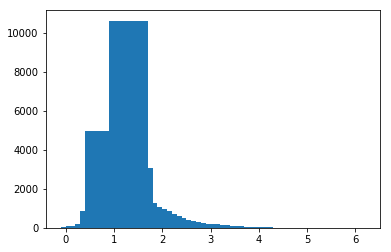

In [41]:
plt.bar(x, y)

In [56]:
df.head()

,image_name
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [118]:
path = PATH/df["image_name"].values[74]
path

PosixPath('/data2/yinterian/mura/MURA-v1.1/train/XR_SHOULDER/patient00027/study1_positive/image1.png')

(512, 406, 3)

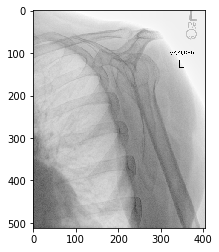

In [113]:
im = read_image(path)
plt.imshow(im)
im.shape

In [120]:
def get_a_crop(path, sz=(270, 350)):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    ratio = r/c
    if ratio > 1.3:
        pad = int((r/1.3-c)/2)
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_CONSTANT)
    else:
        pad = int((1.3*c -r)/2)
        im2 = cv2.copyMakeBorder(im, pad, pad , 0, 0, cv2.BORDER_CONSTANT)
    return cv2.resize(im2, sz)

(350, 270, 3)

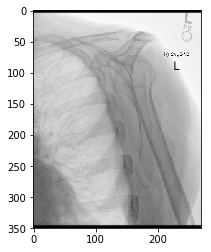

In [121]:
im2 = get_a_crop(path)
plt.imshow(im2)
im2.shape

In [194]:
from os import listdir
from os.path import join
def resize_all_images(df, new_dir):
    for i in range(len(df)):
        row = df.iloc[i,:]
        f = PATH/row["image_name"]
        img = get_a_crop(f)
        new_path = new_dir/"image-{}.png".format(row["image_id"])
        cv2.imwrite(str(new_path), img)

In [195]:
df = pd.read_csv(PATH/"MURA-v1.1/train_path_labels.csv")
df[:4]

,Unnamed: 0,image_name,path,label,image_id
0,0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,0
1,1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,1
2,2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,2
3,3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,3


In [196]:
#resize_all_images(df, PATH/"train_350_270")

In [197]:
df2 = pd.read_csv(PATH/"MURA-v1.1/valid_path_labels.csv")
#resize_all_images(df2, PATH/"valid_350_270")

In [ ]:
df = pd.read_csv(PATH/"MURA-v1.1/train_image_paths.csv", header=None, names=["image_name"])

In [123]:
PATH

PosixPath('/data2/yinterian/mura')

In [116]:
512/406

1.2610837438423645

In [85]:
512/407

1.257985257985258

In [82]:
r/1.3-c

14.846153846153811

## Random transforms

In [4]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x):
    r, c,*_ = x.shape
    r_pix = 8
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [5]:
def norm_for_imageNet(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (img - imagenet_stats[0])/imagenet_stats[1]

In [6]:
class MURAXrayDataSet(Dataset):
    """
    Basic Images DataSet
    Args:
        dataframe with data: image_id, label
        image_path
    """

    def __init__(self, df, image_path, transform=False):
        self.image_id = df["image_id"].values
        self.labels = df["label"].astype(int).values
        self.image_path = image_path
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.image_id[index]
        path = self.image_path/"image-{}.png".format(image_id)
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = norm_for_imageNet(x)
        
        y = self.labels[index]
        y = np.expand_dims(y, axis=-1)
        return np.rollaxis(x, 2), y

    def __len__(self):
        return len(self.image_id)

In [7]:
train = pd.read_csv(PATH/"MURA-v1.1/train_path_labels.csv")
valid = pd.read_csv(PATH/"MURA-v1.1/valid_path_labels.csv")
train_ds = MURAXrayDataSet(train, PATH/"train_350_270", transform=True)
valid_ds = MURAXrayDataSet(valid, PATH/"valid_350_270")

In [8]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## Model 

In [9]:
class DenseNet(nn.Module):
    def __init__(self, out_size=1):
        super(DenseNet, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        layers = list(self.densenet121.children())[0]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:7], layers[7:]]])
        self.groups.append(nn.Linear(1024, out_size))

    def forward(self, x):
        for group in self.groups[:-1]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[-1](x)
        return x

In [10]:
model = DenseNet().cuda()

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [11]:
x,y = next(iter(train_dl))
x = x.float().cuda()
y = y.float().cuda()

In [12]:
pred = model(x)
F.binary_cross_entropy_with_logits(pred, y).item()

0.7063886523246765

## Metrics

In [16]:
def compute_auc(probs, ys):
    probs = np.vstack(probs)
    ys = np.vstack(ys)
    return metrics.roc_auc_score(ys, probs)

In [41]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    probs = []
    ys = []
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        probs.append(out.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        loss = F.binary_cross_entropy_with_logits(out, y.float())
        sum_loss += batch*(loss.item())
        total += batch
    auc = compute_auc(probs, ys)
    return sum_loss/total, auc

In [18]:
val_metric(model, valid_dl)

val loss 0.712 val auc 0.466 



## Training functions

In [19]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

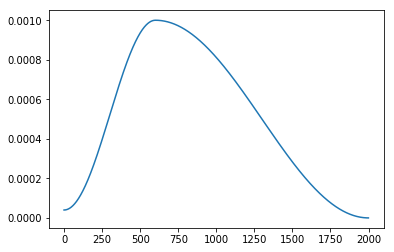

In [20]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [21]:
def diff_lr(lr, alpha=1/3):
    return [lr*alpha**i for i in range(2,-1,-1)]

def create_optimizer(model, lr_0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)]
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, diff_lr(lr_0))]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [46]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_auc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_auc %.3f \n" % 
              (train_loss, val_loss, val_auc))
        if val_auc > prev_val_auc:
            prev_val_auc = val_auc
            path = "{0}/models/model_densenet_auc_1_{1:.0f}.pth".format(PATH, 100*val_auc) 
            save_model(model, path)
            print(path)
    return sum_loss/total

In [25]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [33]:
model = DenseNet().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_high=0.01)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


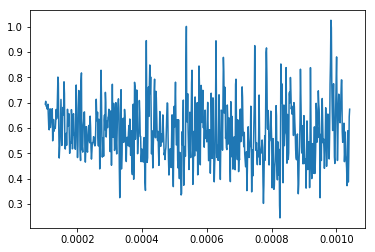

In [40]:
plt.plot(lrs[:700], losses[:700])
plt.show()

## Run Training

In [42]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs = 8)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


train_loss 0.520 val_loss 0.513 val_auc 0.859 

/data2/yinterian/mura/models/model_densenet__auc_86.pth
train_loss 0.497 val_loss 0.485 val_auc 0.865 

/data2/yinterian/mura/models/model_densenet__auc_87.pth
train_loss 0.486 val_loss 0.468 val_auc 0.857 

train_loss 0.456 val_loss 0.439 val_auc 0.875 

/data2/yinterian/mura/models/model_densenet__auc_87.pth
train_loss 0.430 val_loss 0.492 val_auc 0.886 

/data2/yinterian/mura/models/model_densenet__auc_89.pth
train_loss 0.397 val_loss 0.440 val_auc 0.893 

/data2/yinterian/mura/models/model_densenet__auc_89.pth
train_loss 0.364 val_loss 0.412 val_auc 0.896 

/data2/yinterian/mura/models/model_densenet__auc_90.pth
train_loss 0.343 val_loss 0.421 val_auc 0.897 

/data2/yinterian/mura/models/model_densenet__auc_90.pth


0.3429220133315115

In [45]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0005, epochs = 8)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


train_loss 0.529 val_loss 0.503 val_auc 0.840 

/data2/yinterian/mura/models/model_densenet_auc_84.pth
train_loss 0.478 val_loss 0.449 val_auc 0.870 

/data2/yinterian/mura/models/model_densenet_auc_87.pth
train_loss 0.462 val_loss 0.450 val_auc 0.869 

train_loss 0.437 val_loss 0.481 val_auc 0.875 

/data2/yinterian/mura/models/model_densenet_auc_88.pth
train_loss 0.410 val_loss 0.452 val_auc 0.887 

/data2/yinterian/mura/models/model_densenet_auc_89.pth
train_loss 0.376 val_loss 0.412 val_auc 0.893 

/data2/yinterian/mura/models/model_densenet_auc_89.pth
train_loss 0.340 val_loss 0.441 val_auc 0.897 

/data2/yinterian/mura/models/model_densenet_auc_90.pth
train_loss 0.317 val_loss 0.413 val_auc 0.899 

/data2/yinterian/mura/models/model_densenet_auc_90.pth


0.31699625433739814

In [47]:
model = DenseNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.0001, epochs = 8)

/home/yinterian/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


train_loss 0.588 val_loss 0.500 val_auc 0.847 

/data2/yinterian/mura/models/model_densenet_auc_1_85.pth
train_loss 0.478 val_loss 0.476 val_auc 0.866 

/data2/yinterian/mura/models/model_densenet_auc_1_87.pth
train_loss 0.445 val_loss 0.465 val_auc 0.875 

/data2/yinterian/mura/models/model_densenet_auc_1_88.pth
train_loss 0.417 val_loss 0.436 val_auc 0.885 

/data2/yinterian/mura/models/model_densenet_auc_1_88.pth
train_loss 0.388 val_loss 0.434 val_auc 0.889 

/data2/yinterian/mura/models/model_densenet_auc_1_89.pth
train_loss 0.355 val_loss 0.439 val_auc 0.888 

train_loss 0.325 val_loss 0.428 val_auc 0.893 

/data2/yinterian/mura/models/model_densenet_auc_1_89.pth
train_loss 0.308 val_loss 0.453 val_auc 0.893 

/data2/yinterian/mura/models/model_densenet_auc_1_89.pth


0.30751599009207276